# Kepler-1540 b

In [67]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as pl

planets = Table.read('../../planets2.txt', format='csv', comment='#')
K1540b = planets[planets['pl_name'] == 'Kepler-1540 b'][0]
print(K1540b['pl_name', 'sy_jmag', 'st_teff', 'pl_rade'])

   pl_name    sy_jmag st_teff pl_rade
------------- ------- ------- -------
Kepler-1540 b   12.25  4641.0    3.14


### Compute the probabilistic mass using Kipping & Chen: https://iopscience.iop.org/article/10.3847/1538-4357/834/1/17

In [82]:
import sys
sys.path.append('/Users/tgordon/research/exomoons/forecaster')
import mr_forecast as mr

res = mr.Rstat2M(mean=K1540b['pl_rade'] / 11.2089 , std=K1540b['pl_radeerr1'] / 11.2089, unit='Jupiter', sample_size=1000, grid_size=200)
print(res)

(0.031471569199327296, 0.021497693198587603, 0.012772806501301932)


### Compute the hill sphere

In [83]:
mj_ms = 0.0009543
hill = lambda mp, ms, a, e: a * (1 - e) * (mp * mj_ms/(3*ms)) ** (1./3.)

#a = 0.718, 0.711, 0.725
#e = 0.094, 0.0, 0.262
a = 0.4426, 0.4426, 0.4426
e = 0, 0, 0
likely_hill = hill(res[0], K1540b['st_mass'], a[0], e[0])
pessimistic_hill = hill(res[0]-res[1], K1540b['st_mass']-0.03, a[1], e[2])
optimistic_hill = hill(res[0]+res[1], K1540b['st_mass']+0.04, a[2], e[1])
print(likely_hill, " ", pessimistic_hill, " ", optimistic_hill)

0.010594110013279019   0.0073246679376509916   0.012379707000153959


### Look at the light curve to assess variability and rotation:

In [84]:
import lightkurve as lk
lcfs = lk.search_lightcurvefile('Kepler-1540', mission='Kepler').download_all()
lc = lcfs.PDCSAP_FLUX.stitch()

/usr/local/lib/python3.7/site-packages/lightkurve/lightcurvefile.py:47: LightkurveWarning: `LightCurveFile.header` is deprecated, please use `LightCurveFile.get_header()` instead.
  LightkurveWarning)


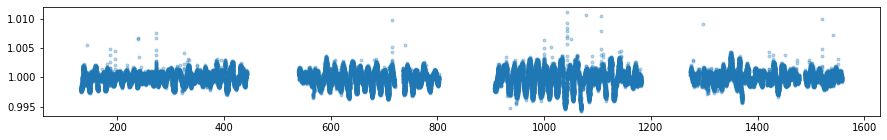

In [58]:
clipped_lc = lc.remove_outliers(sigma=10)

pl.figure(figsize=(15, 2))
pl.plot(clipped_lc.time, clipped_lc.flux, '.', alpha=0.3)

### Compute the power spectrum of the combined Kepler light curve

(1, 100000.0)

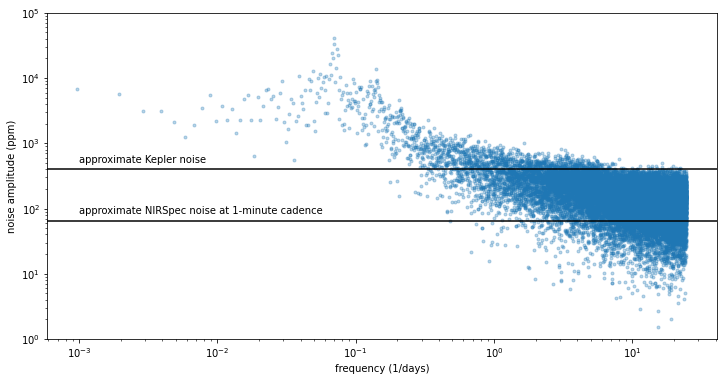

In [65]:
f = np.fft.rfftfreq(len(clipped_lc.flux), clipped_lc.time[1] - clipped_lc.time[0])
fft = np.fft.rfft(clipped_lc.flux)
fft = fft*np.conj(fft)
powerfft = fft.real / len(clipped_lc.time)**2
ampfft = np.sqrt(powerfft * (60 * 60 * 24) / (2*np.pi)) * 1e6

pl.figure(figsize=(12, 6))
pl.loglog(f, ampfft, '.', alpha=0.3)

pl.axhline(400, color='k')
pl.axhline(65, color='k')
pl.annotate(s='approximate Kepler noise', xy=(1e-3, 500))
pl.annotate(s='approximate NIRSpec noise at 1-minute cadence', xy=(1e-3, 82))

pl.ylabel("noise amplitude (ppm)")
pl.xlabel("frequency (1/days)")

pl.ylim(1, 1e5)

Additional references: 



- Fit multi-component 1D celerite kernel  
- Use long-timsecale components of GP fit to decorrelate longer timescale variability, with the goal of leaving the barely visible granulation component. 
- Check against PSD 
- Use Kepler band & phoenix models to solve for the covering fraction x(t) using equation (8) with the temperature contrasts from figure (9) of https://arxiv.org/pdf/1405.7628.pdf
- Reconstruct spectral time-series using the same phoenix models and reconstructing x(t) by GP prediction on the Kepler time-series. 

In [85]:
K1540b['pl_rade']

3.14